# 02 — Feature Engineering e Análise Exploratória Ampliada

Projeto: Modelo Preditivo de Qualidade do Ar e Riscos à Saúde (Canoas como proxy de Porto Alegre)  
Período: 2020–2024

Este notebook unifica e amplia o conteúdo do antigo `02_Feature_Engineering.ipynb`, incorporando novas variáveis e análises:
- Leitura do dataset de features gerado pelo pipeline (`air_quality_features.csv`).
- Verificações de consistência, completude e período.
- Séries temporais, decomposição sazonal e sazonalidade mensal/estacional para PM10 e lags.
- Distribuições e outliers para poluentes e variáveis meteorológicas.
- Correlações entre poluentes, meteorologia e saúde.
- Análises bivariadas (dispersão) de PM10 com umidade, temperatura, vento e internações respiratórias.
- Salvamento de todos os gráficos em `../reports/figures/`.

In [34]:
# Configuração inicial
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.tsa.seasonal import seasonal_decompose

# Plotly é opcional; se não houver kaleido, salvaremos HTML
try:
    import plotly.express as px
    import plotly.graph_objects as go
    PLOTLY_OK = True
except Exception:
    PLOTLY_OK = False

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_context("talk")

# Caminhos
FIG_PATH = Path('../reports/figures')
FIG_PATH.mkdir(parents=True, exist_ok=True)
DATA_FEATURES = Path('../data/processed/air_quality_features.csv')
DATA_PROCESSED = Path('../data/processed/air_quality_processed.csv')

def save_plotly(fig, filename_png: str, filename_html: str = None):
    """Salva figura plotly. Se kaleido indisponível, salva HTML."""
    if not PLOTLY_OK:
        return
    if filename_html is None:
        filename_html = filename_png.replace('.png', '.html')
    try:
        fig.write_image(str(FIG_PATH / filename_png))
    except Exception:
        fig.write_html(str(FIG_PATH / filename_html))

def safe_savefig(fname: str, dpi: int = 300, bbox_inches: str = 'tight'):
    try:
        plt.savefig(FIG_PATH / fname, dpi=dpi, bbox_inches=bbox_inches)
    except Exception:
        pass


## 1. Carregamento do Dataset
Preferencialmente, carregamos `air_quality_features.csv` (saída do pipeline de features). Caso não exista, carregamos `air_quality_processed.csv` e seguimos apenas com análises básicas.

In [35]:
# Leitura dos dados
if DATA_FEATURES.exists():
    df = pd.read_csv(DATA_FEATURES, parse_dates=['datetime'])
else:
    df = pd.read_csv(DATA_PROCESSED, parse_dates=['datetime'])

df = df.sort_values('datetime').set_index('datetime')

# Garantir timezone consistente
if df.index.tz is None:
    try:
        df.index = df.index.tz_localize('America/Sao_Paulo')
    except Exception:
        # Caso falhe a localização, mantemos naive
        pass
else:
    try:
        df.index = df.index.tz_convert('America/Sao_Paulo')
    except Exception:
        pass

print("Dimensões do dataset:")
print(f"Registros: {len(df):,}")
print(f"Variáveis: {df.shape[1]:,}")
print("Período coberto:")
try:
    print(df.index.min().strftime('%d/%m/%Y'), 'a', df.index.max().strftime('%d/%m/%Y'))
except Exception:
    print(df.index.min(), 'a', df.index.max())

# Colunas de interesse
poluentes = [c for c in df.columns if any(x in c for x in ['PM10_Canoas', 'NO2_Canoas', 'O3_Canoas', 'SO2_Canoas', 'CO_Canoas'])]
meteo = [c for c in ['temperatura', 'umidade', 'vento_velocidade', 'vento_direcao', 'precipitacao', 'dispersao_index', 'vento_log', 'temp_diff_daynight'] if c in df.columns]
saude_cols = [c for c in ['internacoes_respiratorias', 'internacoes_lag1', 'internacoes_lag3', 'internacoes_roll3', 'internacoes_roll7'] if c in df.columns]
lag_targets = [c for c in ['PM10_next_day', 'PM10_next_3d'] if c in df.columns]
aqui_cols = [c for c in ['AQI_category_next_1d', 'AQI_category_next_3d'] if c in df.columns]

print('\nColunas detectadas:')
print('Poluentes:', poluentes)
print('Meteorologia:', meteo)
print('Saúde:', saude_cols)
print('Targets futuros:', lag_targets)
print('AQI futuros:', aqui_cols)


Dimensões do dataset:
Registros: 899
Variáveis: 139
Período coberto:
01/01/2020 a 28/12/2024

Colunas detectadas:
Poluentes: ['CO_Canoas', 'NO2_Canoas', 'O3_Canoas', 'SO2_Canoas', 'PM10_Canoas', 'PM10_Canoas_lag_1', 'PM10_Canoas_lag_2', 'PM10_Canoas_lag_3', 'PM10_Canoas_lag_7', 'CO_Canoas_lag1', 'CO_Canoas_lag2', 'CO_Canoas_lag3', 'CO_Canoas_lag7', 'CO_Canoas_rolling_mean_3', 'CO_Canoas_rolling_mean_7', 'CO_Canoas_rolling_std_7', 'CO_Canoas_rolling_min_7', 'CO_Canoas_rolling_max_7', 'NO2_Canoas_lag1', 'NO2_Canoas_lag2', 'NO2_Canoas_lag3', 'NO2_Canoas_lag7', 'NO2_Canoas_rolling_mean_3', 'NO2_Canoas_rolling_mean_7', 'NO2_Canoas_rolling_std_7', 'NO2_Canoas_rolling_min_7', 'NO2_Canoas_rolling_max_7', 'O3_Canoas_lag1', 'O3_Canoas_lag2', 'O3_Canoas_lag3', 'O3_Canoas_lag7', 'O3_Canoas_rolling_mean_3', 'O3_Canoas_rolling_mean_7', 'O3_Canoas_rolling_std_7', 'O3_Canoas_rolling_min_7', 'O3_Canoas_rolling_max_7', 'SO2_Canoas_lag1', 'SO2_Canoas_lag2', 'SO2_Canoas_lag3', 'SO2_Canoas_lag7', 'SO2_Cano

## 2. Qualidade e Completude
Resumo de valores faltantes por variável e gráfico de missingness.

,missing,missing_%
CO_Canoas_lag7,689,76.64
CO_Canoas_lag3,687,76.42
CO_Canoas_lag2,686,76.31
CO_Canoas_lag1,685,76.20
CO_Canoas,684,76.08
CO_Canoas_rolling_mean_3,682,75.86
CO_Canoas_rolling_std_7,681,75.75
CO_Canoas_rolling_min_7,678,75.42
CO_Canoas_rolling_mean_7,678,75.42
CO_Canoas_rolling_max_7,678,75.42


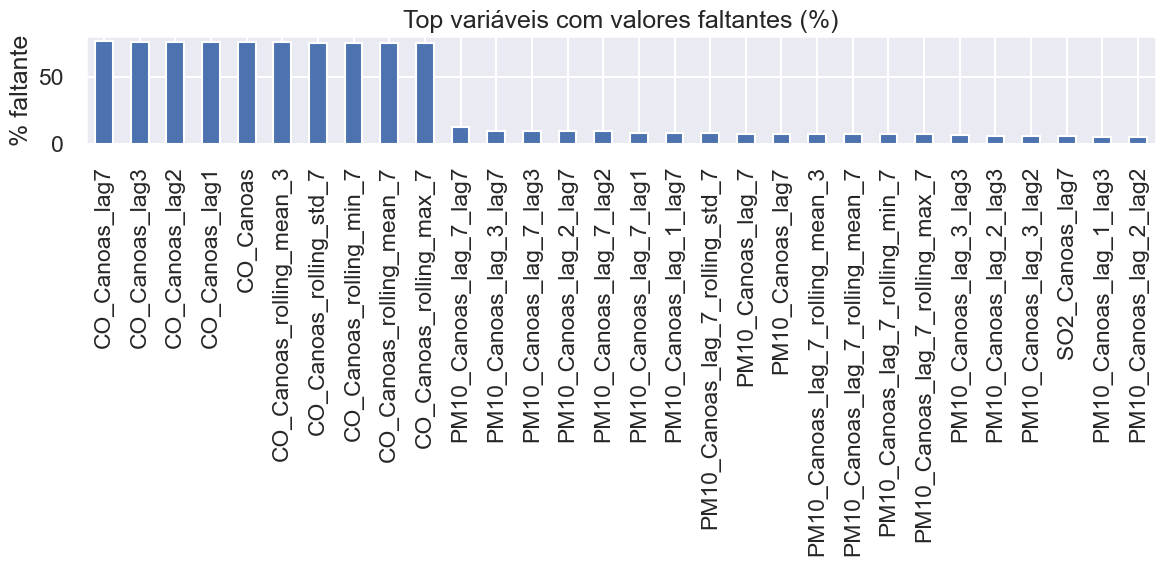

In [36]:
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
miss_df = pd.DataFrame({'missing': missing, 'missing_%': missing_pct})
display(miss_df.head(20))

plt.figure(figsize=(12,6))
miss_df.query('missing > 0').head(30)['missing_%'].plot(kind='bar')
plt.title('Top variáveis com valores faltantes (%)')
plt.ylabel('% faltante')
plt.tight_layout()
safe_savefig('fe_missing_top.png')
plt.show()


## 3. Séries Temporais
Série de PM10 em Canoas e de targets futuros (quando disponíveis). Também salvamos as versões interativas, quando possível.

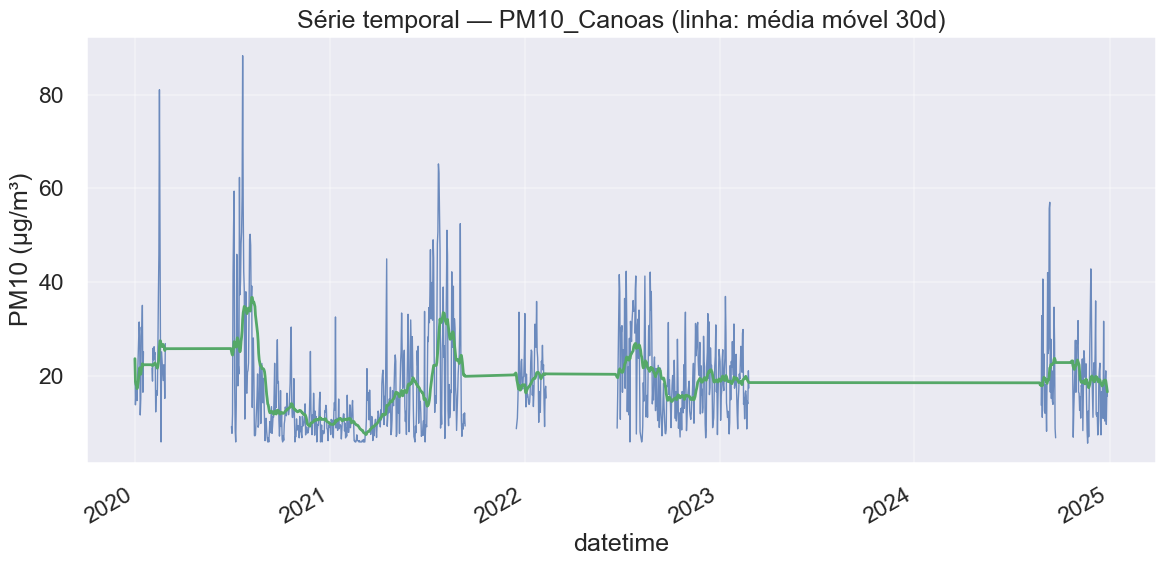

2025-10-21 11:46:36,505 - INFO - Chromium init'ed with kwargs {}
2025-10-21 11:46:36,508 - INFO - Found chromium path: C:\Program Files\Google\Chrome\Application\chrome.exe
2025-10-21 11:46:36,509 - INFO - Temp directory created: C:\Users\julia\AppData\Local\Temp\tmpmsqmhuuh.
2025-10-21 11:46:36,512 - INFO - Opening browser.
2025-10-21 11:46:36,514 - INFO - Temp directory created: C:\Users\julia\AppData\Local\Temp\tmpnjkqlnon.
2025-10-21 11:46:36,516 - INFO - Temporary directory at: C:\Users\julia\AppData\Local\Temp\tmpnjkqlnon
2025-10-21 11:46:36,842 - INFO - Conforming 1 to file:///C:/Users/julia/AppData/Local/Temp/tmpmsqmhuuh/index.html
2025-10-21 11:46:36,846 - INFO - Waiting on all navigates
2025-10-21 11:46:38,754 - INFO - All navigates done, putting them all in queue.
2025-10-21 11:46:38,755 - INFO - Getting tab from queue (has 1)
2025-10-21 11:46:38,756 - INFO - Got BC72
2025-10-21 11:46:38,758 - INFO - Processing Srie_temporal__PM10_Canoas.png
2025-10-21 11:46:38,759 - INFO - 

2025-10-21 11:46:39,309 - INFO - TemporaryDirectory.cleanup() worked.
2025-10-21 11:46:39,309 - INFO - shutil.rmtree worked.


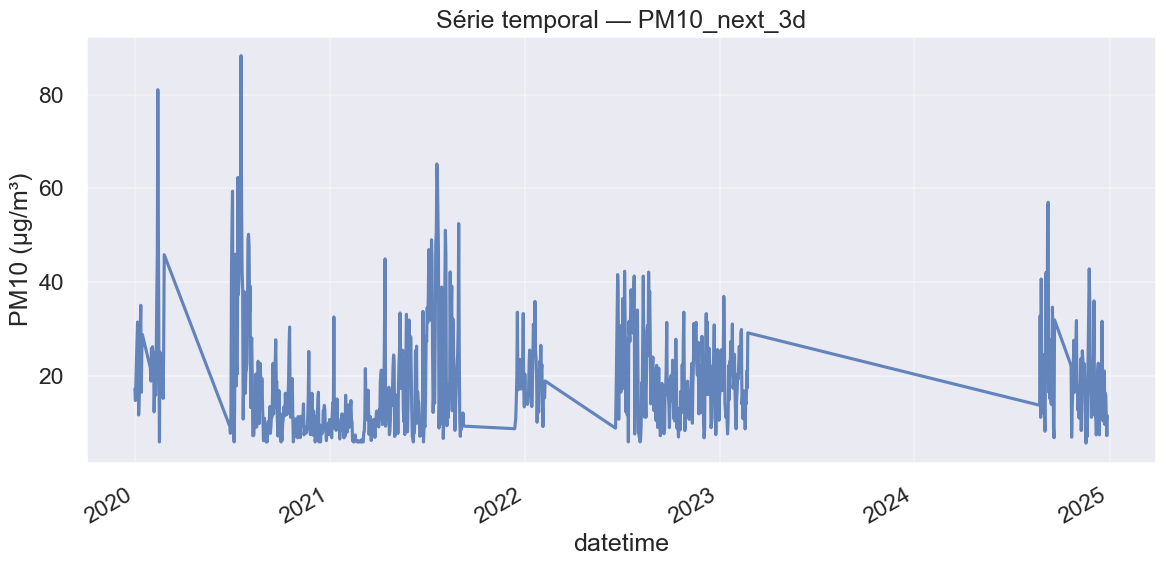

2025-10-21 11:46:39,934 - INFO - Chromium init'ed with kwargs {}
2025-10-21 11:46:39,939 - INFO - Found chromium path: C:\Program Files\Google\Chrome\Application\chrome.exe
2025-10-21 11:46:39,941 - INFO - Temp directory created: C:\Users\julia\AppData\Local\Temp\tmpt3ak9yj3.
2025-10-21 11:46:39,943 - INFO - Opening browser.
2025-10-21 11:46:39,947 - INFO - Temp directory created: C:\Users\julia\AppData\Local\Temp\tmpmz1rqafy.
2025-10-21 11:46:39,951 - INFO - Temporary directory at: C:\Users\julia\AppData\Local\Temp\tmpmz1rqafy
2025-10-21 11:46:40,310 - INFO - Conforming 1 to file:///C:/Users/julia/AppData/Local/Temp/tmpt3ak9yj3/index.html
2025-10-21 11:46:40,312 - INFO - Waiting on all navigates
2025-10-21 11:46:41,637 - INFO - All navigates done, putting them all in queue.
2025-10-21 11:46:41,639 - INFO - Getting tab from queue (has 1)
2025-10-21 11:46:41,640 - INFO - Got E33B
2025-10-21 11:46:41,641 - INFO - Processing Srie_temporal__PM10_next_3d.png
2025-10-21 11:46:41,643 - INFO -

In [37]:
if 'PM10_Canoas' in df.columns:
    ax = df['PM10_Canoas'].plot(alpha=0.8, linewidth=1)
    df['PM10_Canoas'].rolling(30, min_periods=1).mean().plot(ax=ax, linewidth=2)
    plt.title('Série temporal — PM10_Canoas (linha: média móvel 30d)')
    plt.ylabel('PM10 (µg/m³)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    safe_savefig('fe_serie_PM10_Canoas.png')
    plt.show()

    if PLOTLY_OK:
        fig = px.line(df.reset_index(), x='datetime', y='PM10_Canoas', title='Série temporal — PM10_Canoas')
        save_plotly(fig, 'fe_serie_PM10_Canoas_interativo.png')
        fig.show()

for tgt in ['PM10_next_day', 'PM10_next_3d']:
    if tgt in df.columns:
        ax = df[tgt].plot(alpha=0.85)
        plt.title(f'Série temporal — {tgt}')
        plt.ylabel('PM10 (µg/m³)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        safe_savefig(f'fe_serie_{tgt}.png')
        plt.show()
        if PLOTLY_OK:
            fig = px.line(df.reset_index(), x='datetime', y=tgt, title=f'Série temporal — {tgt}')
            save_plotly(fig, f'fe_serie_{tgt}_interativo.png')
            fig.show()


## 4. Decomposição Sazonal (PM10)
Decomposição aditiva com período anual aproximado (365). Requer série relativamente completa.

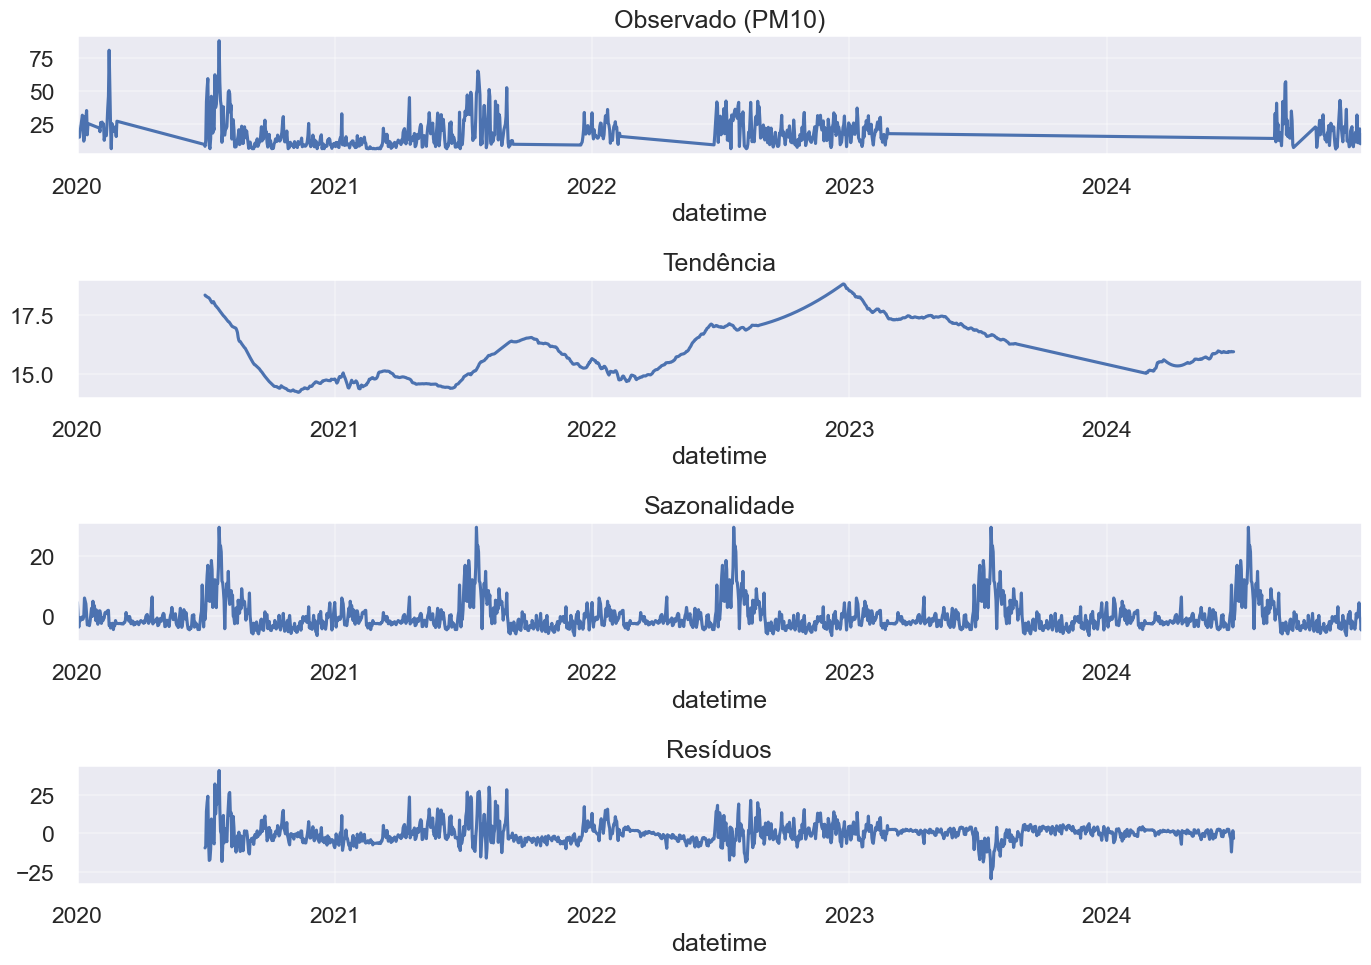

In [38]:
if 'PM10_Canoas' in df.columns and df['PM10_Canoas'].dropna().shape[0] > 380:
    s = df['PM10_Canoas'].resample('D').mean()
    s = s.interpolate(limit_direction='both')

    try:
        res = seasonal_decompose(s, model='additive', period=365)
        fig, axes = plt.subplots(4, 1, figsize=(14, 10))
        res.observed.plot(ax=axes[0]); axes[0].set_title('Observado (PM10)')
        res.trend.plot(ax=axes[1]); axes[1].set_title('Tendência')
        res.seasonal.plot(ax=axes[2]); axes[2].set_title('Sazonalidade')
        res.resid.plot(ax=axes[3]); axes[3].set_title('Resíduos')
        for ax in axes: ax.grid(True, alpha=0.3)
        plt.tight_layout()
        safe_savefig('fe_decomposicao_PM10.png')
        plt.show()
    except Exception as e:
        print('Decomposição não executada:', e)
else:
    print('Série insuficiente para decomposição anual (requer > 380 observações válidas).')


## 5. Distribuições e Outliers
Histogramas e boxplots para PM10 e poluentes. Identificação de outliers via IQR (informativo).

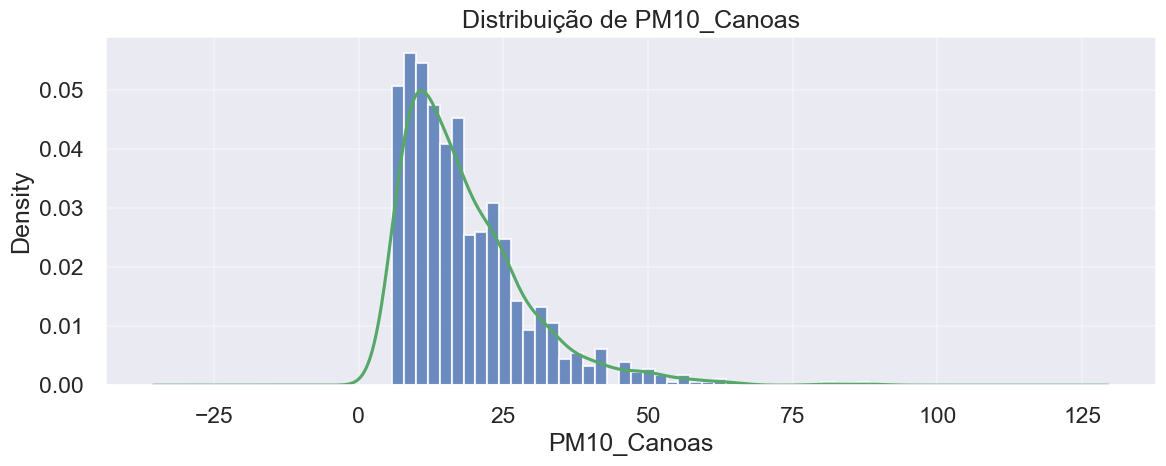

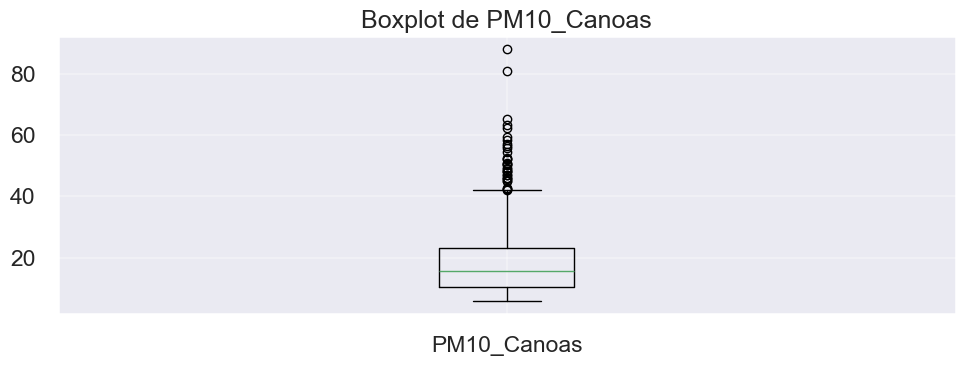

PM10_Canoas: limites IQR [-8.58, 42.20] — outliers: 34


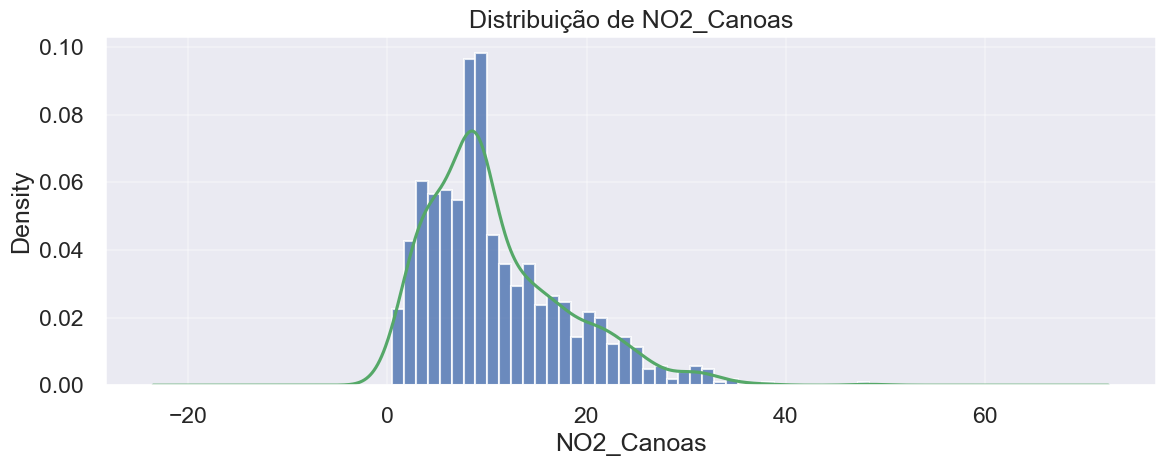

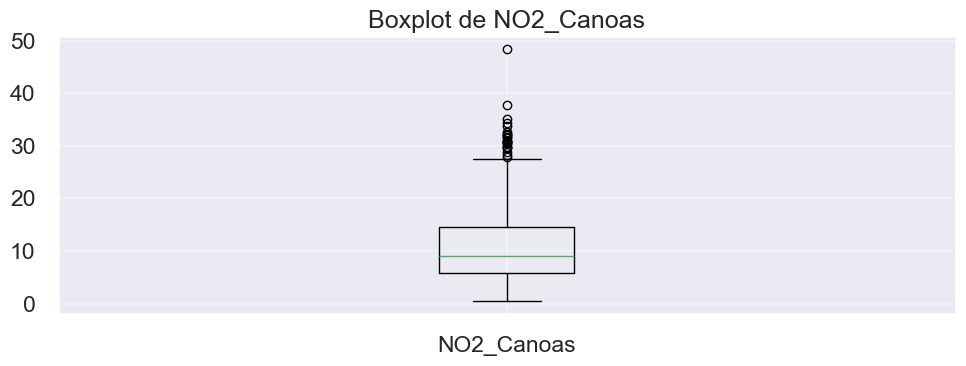

NO2_Canoas: limites IQR [-7.00, 27.40] — outliers: 23


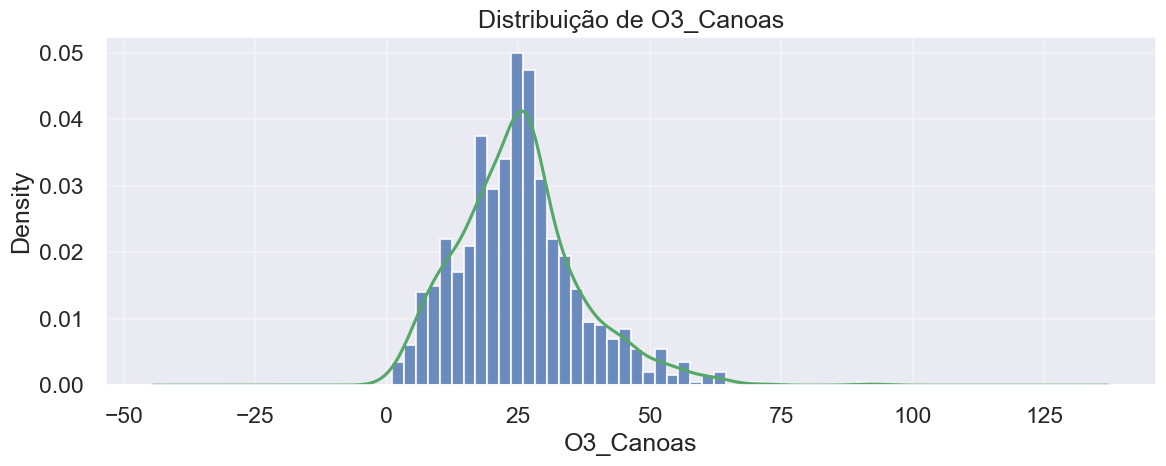

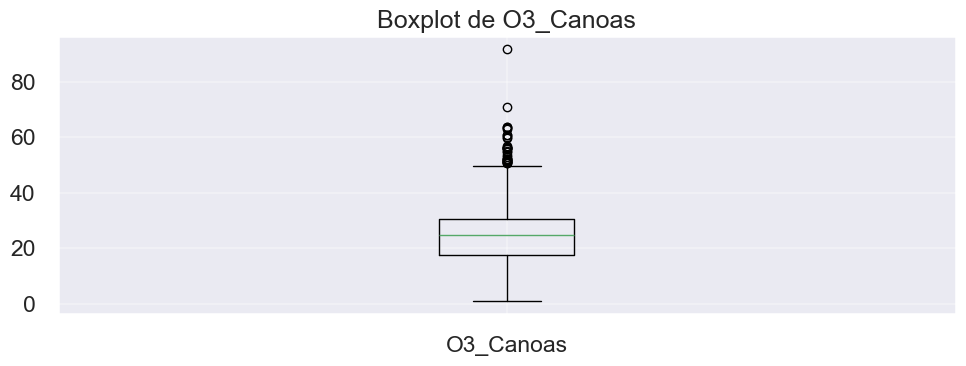

O3_Canoas: limites IQR [-2.09, 50.30] — outliers: 33


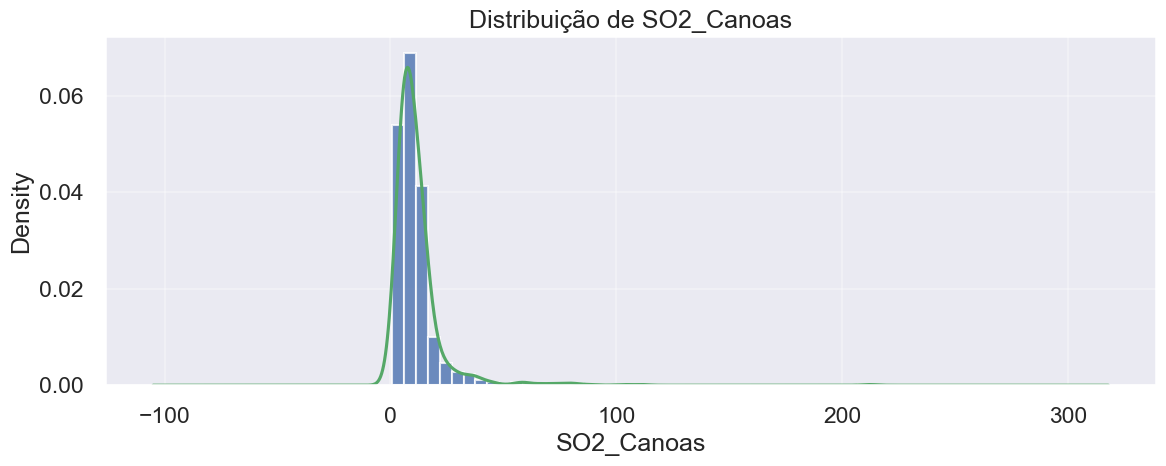

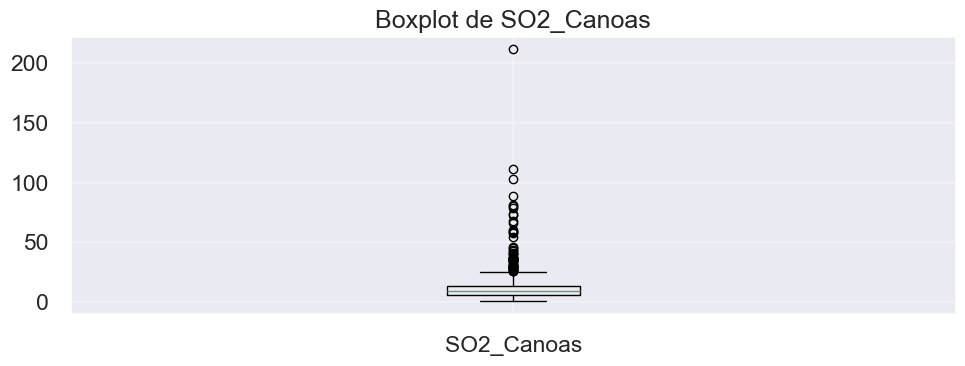

SO2_Canoas: limites IQR [-6.45, 25.68] — outliers: 52


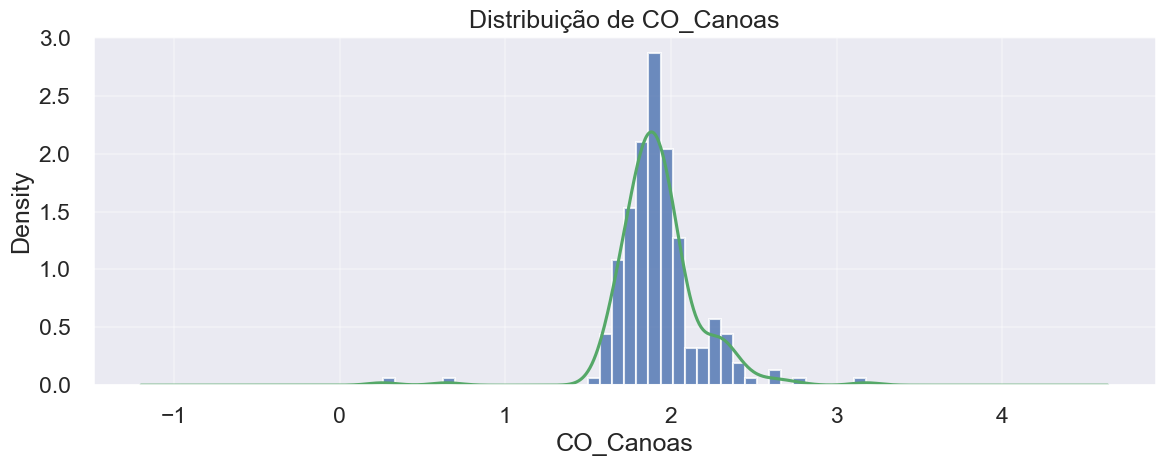

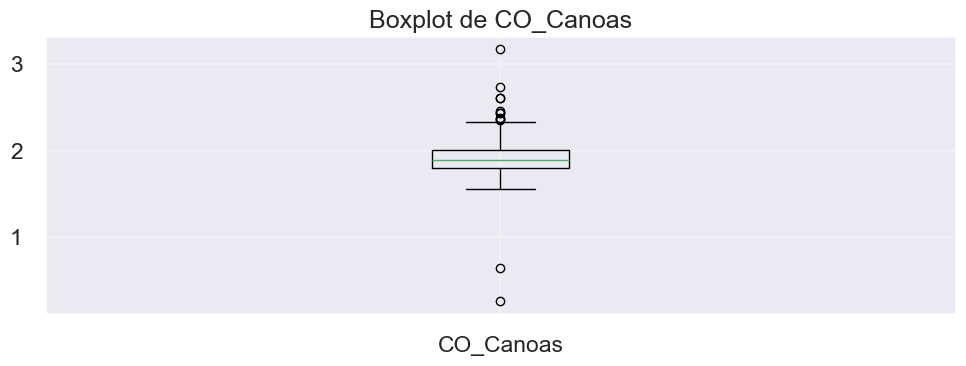

CO_Canoas: limites IQR [1.47, 2.33] — outliers: 12


In [39]:
dist_cols = [c for c in ['PM10_Canoas','NO2_Canoas','O3_Canoas','SO2_Canoas','CO_Canoas'] if c in df.columns]
for col in dist_cols:
    data = df[col].dropna()
    if data.empty:
        continue
    fig, ax = plt.subplots(figsize=(12,5))
    ax.hist(data, bins=40, alpha=0.8, density=True)
    data.plot(kind='kde', ax=ax, secondary_y=False)
    ax.set_title(f'Distribuição de {col}')
    ax.set_xlabel(col)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    safe_savefig(f'fe_dist_{col}.png')
    plt.show()

    fig, ax = plt.subplots(figsize=(10,4))
    ax.boxplot(data, vert=True, labels=[col])
    ax.set_title(f'Boxplot de {col}')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    safe_savefig(f'fe_box_{col}.png')
    plt.show()

    q1, q3 = data.quantile(0.25), data.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    n_out = ((data < lower) | (data > upper)).sum()
    print(f"{col}: limites IQR [{lower:.2f}, {upper:.2f}] — outliers: {n_out}")


## 6. Sazonalidade Mensal e por Estação
Boxplots mensais e por estação do ano (mapeando DJF=verão, MAM=outono, JJA=inverno, SON=primavera) para PM10 e lags principais, quando existirem.

2025-10-21 11:46:47,775 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 11:46:47,780 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


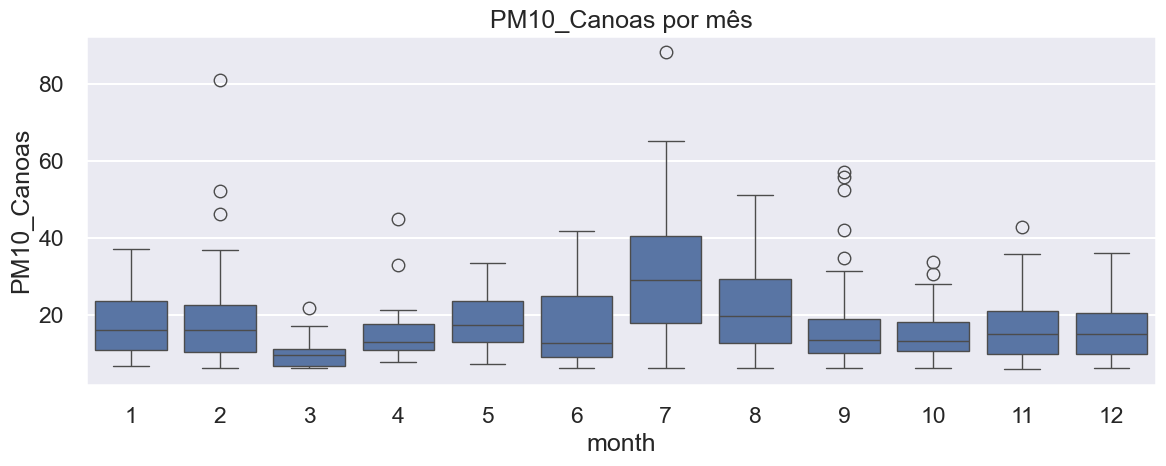

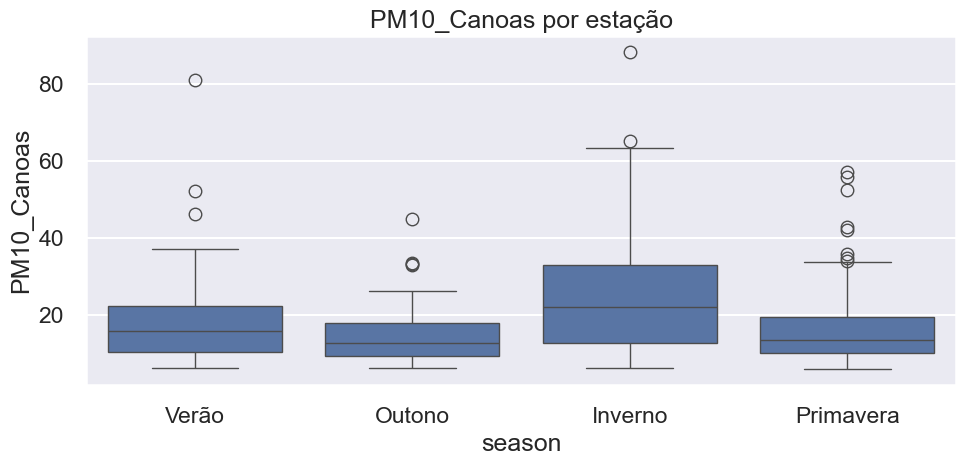

2025-10-21 11:46:48,549 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 11:46:48,549 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


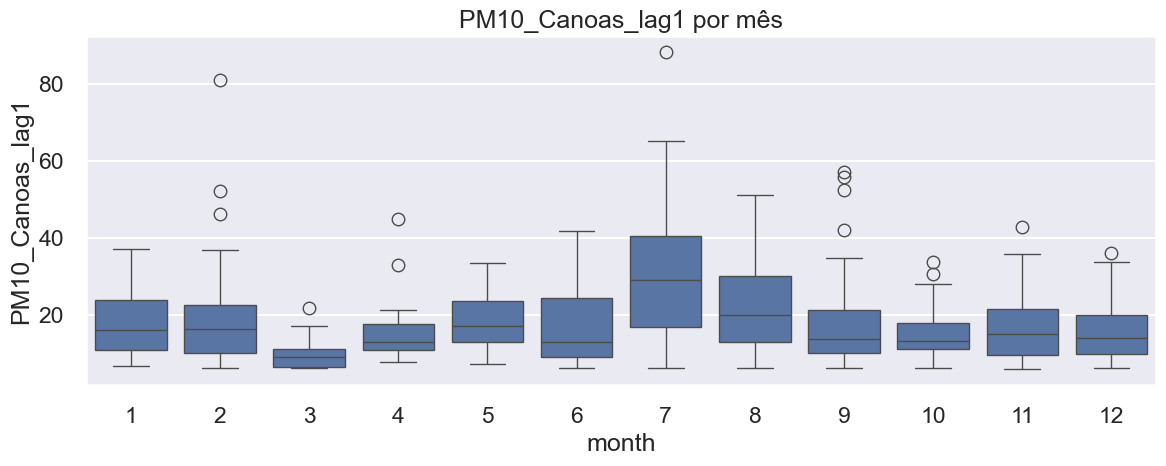

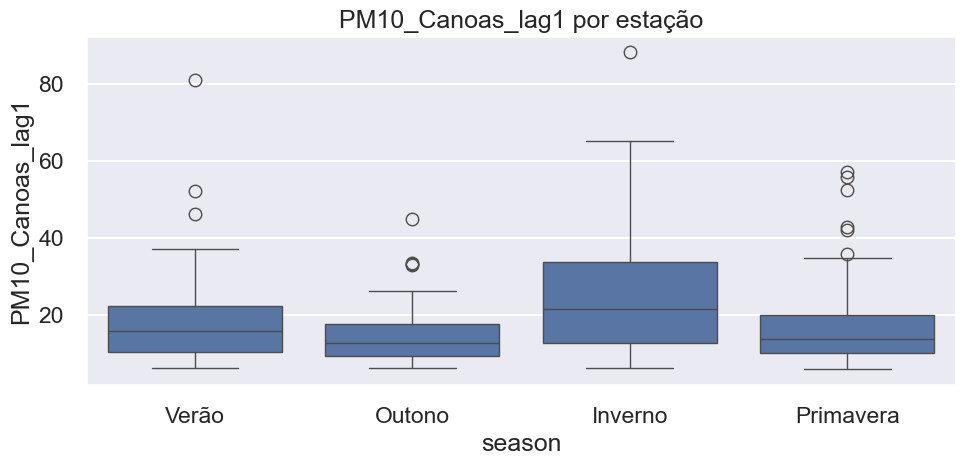

2025-10-21 11:46:49,298 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 11:46:49,303 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


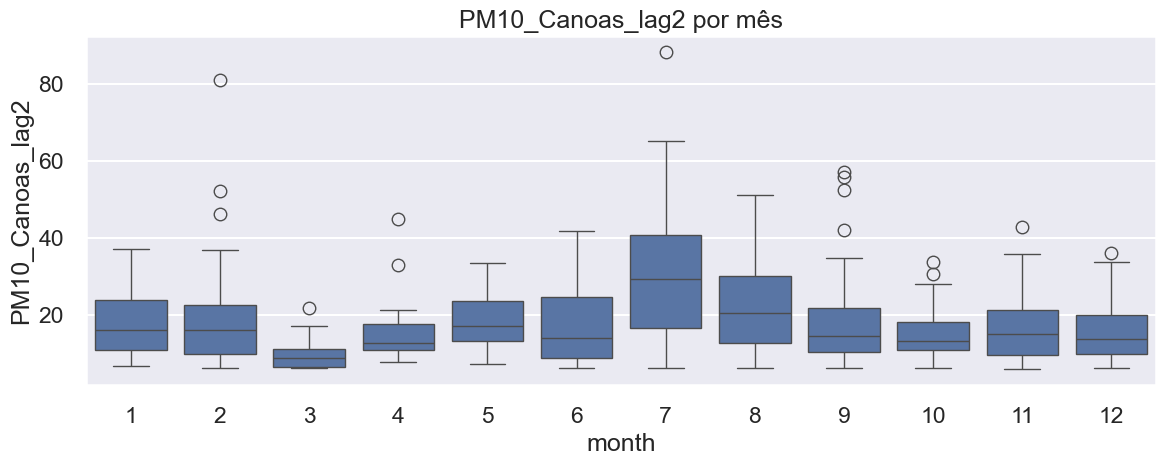

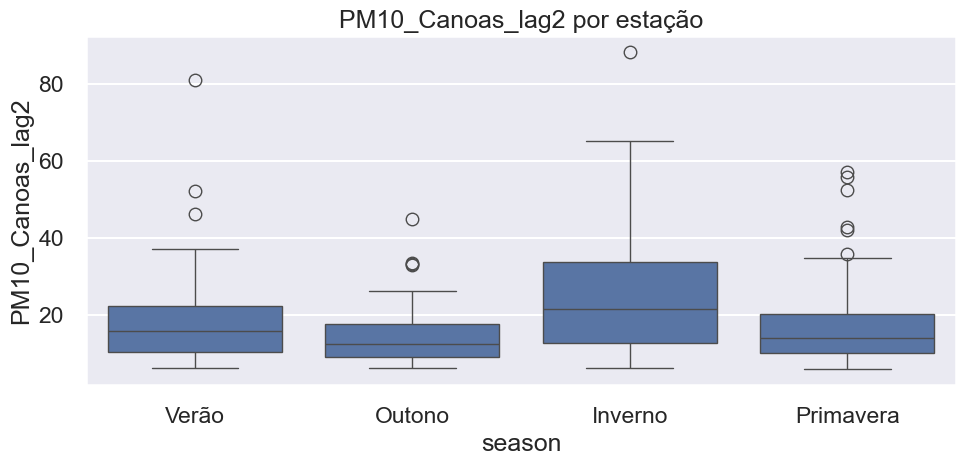

2025-10-21 11:46:50,042 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 11:46:50,042 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


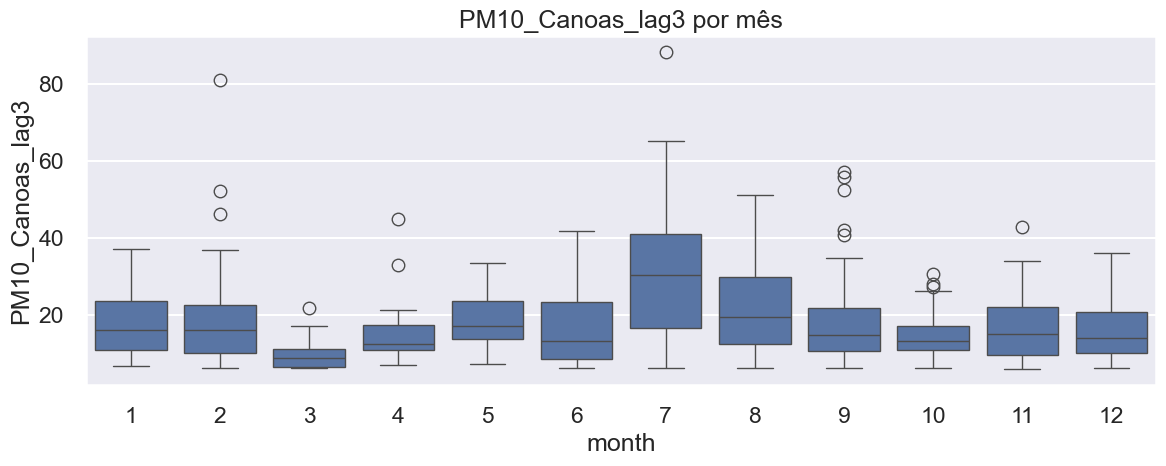

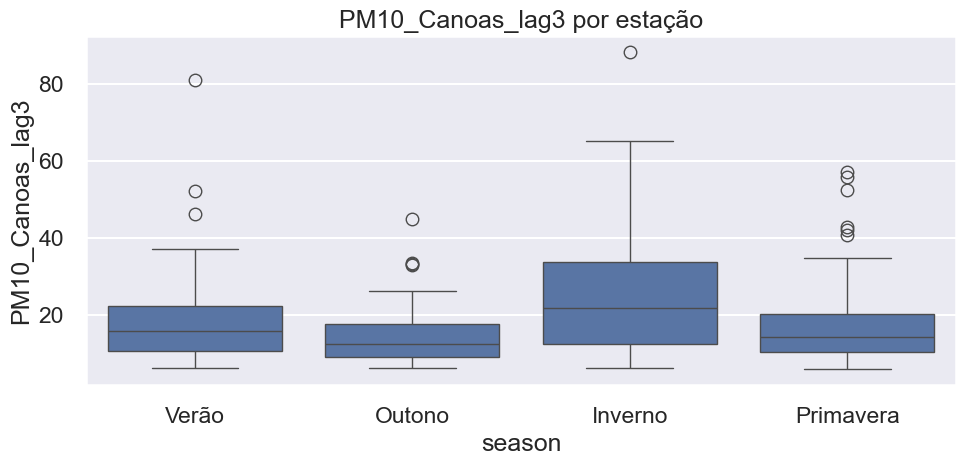

2025-10-21 11:46:50,816 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 11:46:50,824 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


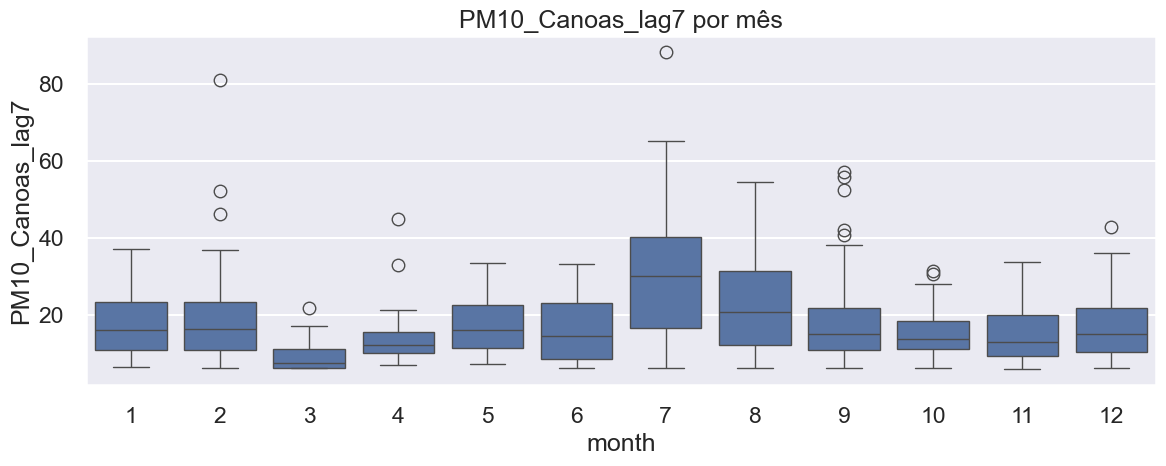

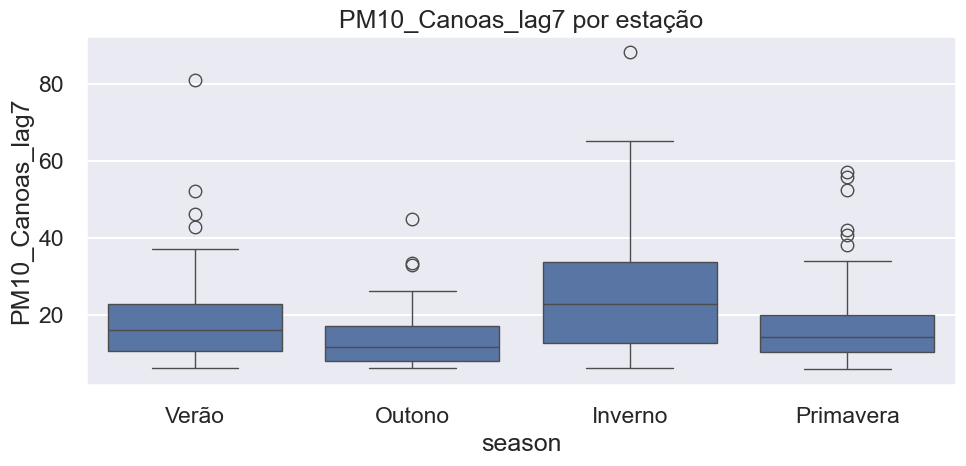

In [40]:
df_season = df.copy()
df_season['month'] = df_season.index.month.astype(int)

def month_to_season(m):
    if m in [12, 1, 2]: return 'Verão'
    if m in [3, 4, 5]: return 'Outono'
    if m in [6, 7, 8]: return 'Inverno'
    return 'Primavera'

df_season['season'] = df_season['month'].apply(month_to_season)

season_cols = [c for c in ['PM10_Canoas','PM10_Canoas_lag1','PM10_Canoas_lag2','PM10_Canoas_lag3','PM10_Canoas_lag7'] if c in df.columns]

for col in season_cols:
    tmp = df_season[[col, 'month','season']].dropna().copy()
    if tmp.empty:
        continue

    # Converter mês e estação explicitamente para categorias
    tmp['month'] = pd.Categorical(tmp['month'], categories=range(1,13), ordered=True)
    tmp['season'] = pd.Categorical(tmp['season'], categories=['Verão','Outono','Inverno','Primavera'], ordered=True)

    plt.figure(figsize=(12,5))
    sns.boxplot(data=tmp, x='month', y=col)
    plt.title(f'{col} por mês')
    plt.tight_layout()
    safe_savefig(f'fe_box_mensal_{col}.png')
    plt.show()

    plt.figure(figsize=(10,5))
    sns.boxplot(data=tmp, x='season', y=col)
    plt.title(f'{col} por estação')
    plt.tight_layout()
    safe_savefig(f'fe_box_estacao_{col}.png')
    plt.show()


## 7. Correlações
Matriz de correlação abrangendo poluentes, meteorologia e variáveis de saúde (se existentes).

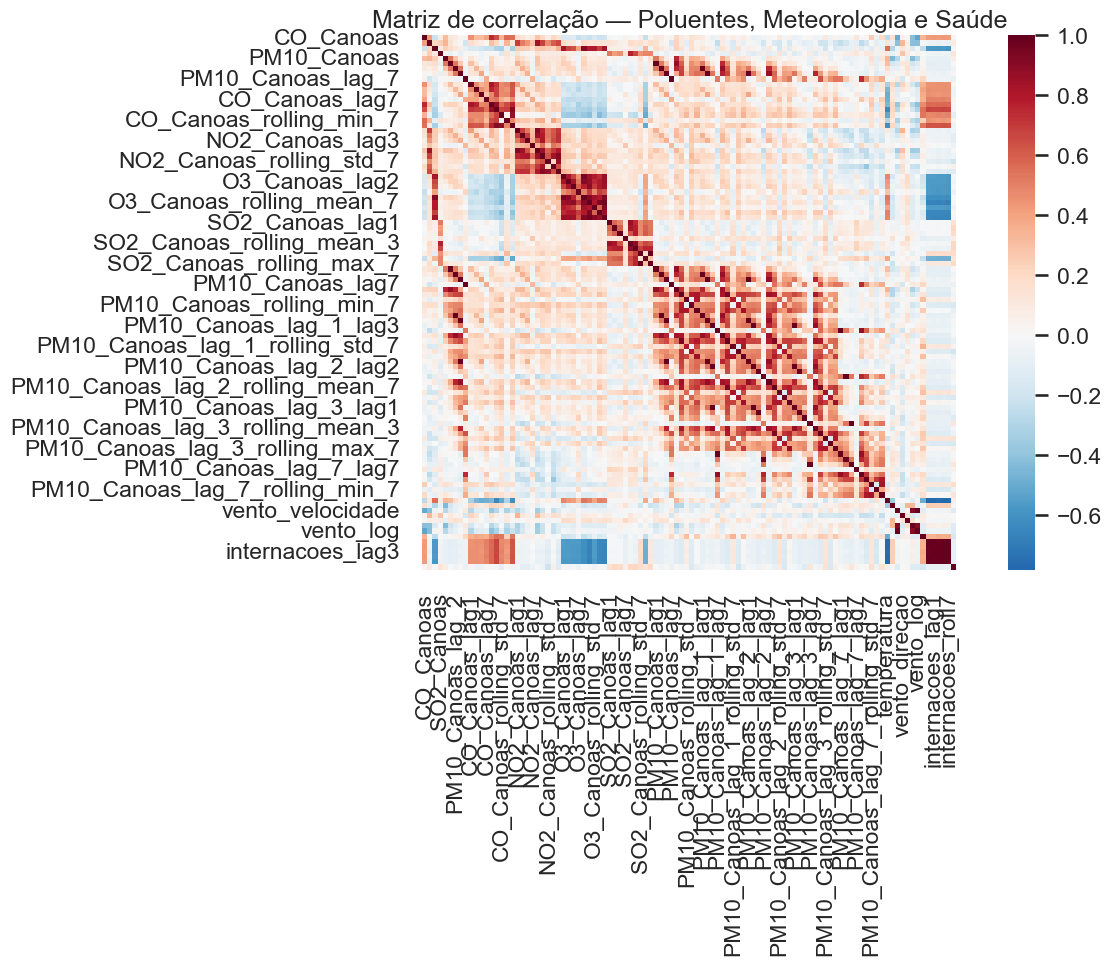

In [41]:
corr_cols = list(dict.fromkeys([
    *[c for c in poluentes if df[c].dtype.kind in 'if'],
    *[c for c in meteo if df[c].dtype.kind in 'if'],
    *[c for c in saude_cols if df[c].dtype.kind in 'if'],
    *[c for c in lag_targets if c in df.columns and df[c].dtype.kind in 'if']
]))

corr_df = df[corr_cols].dropna().copy() if corr_cols else pd.DataFrame()
if not corr_df.empty:
    corr = corr_df.corr()
    plt.figure(figsize=(14,10))
    sns.heatmap(corr, cmap='RdBu_r', center=0, annot=False, square=True)
    plt.title('Matriz de correlação — Poluentes, Meteorologia e Saúde')
    plt.tight_layout()
    safe_savefig('fe_heatmap_correlacoes.png')
    plt.show()
else:
    print('Sem colunas numéricas suficientes para correlação.')


## 8. Relações Bivariadas com PM10
Dispersões entre PM10 e meteorologia; e entre PM10 futuro (quando disponível) e internações. Adicionamos linha de tendência linear simples para referência visual.

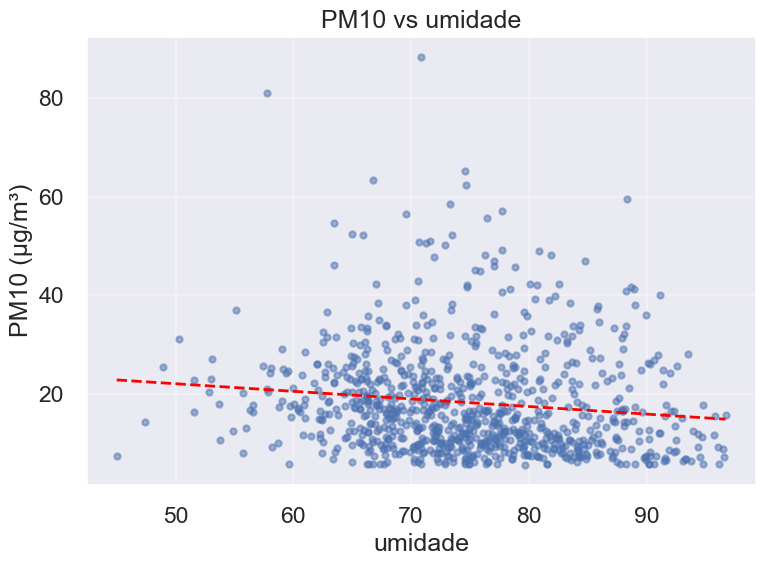

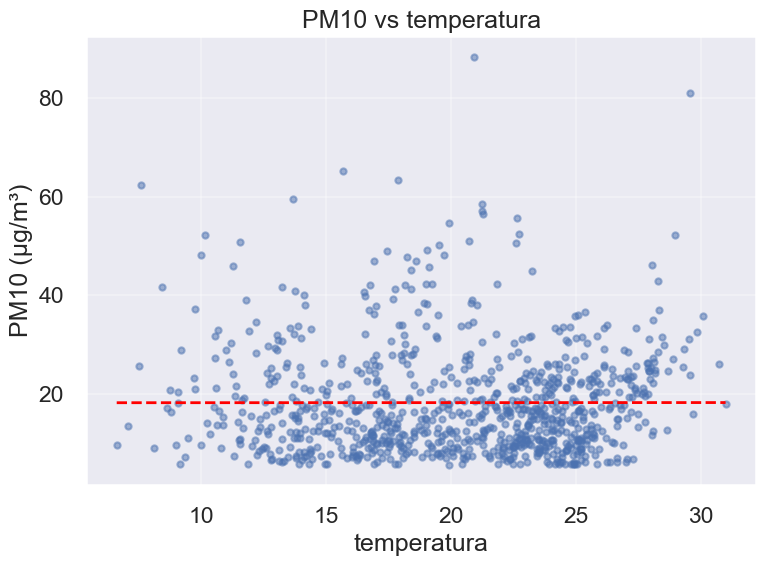

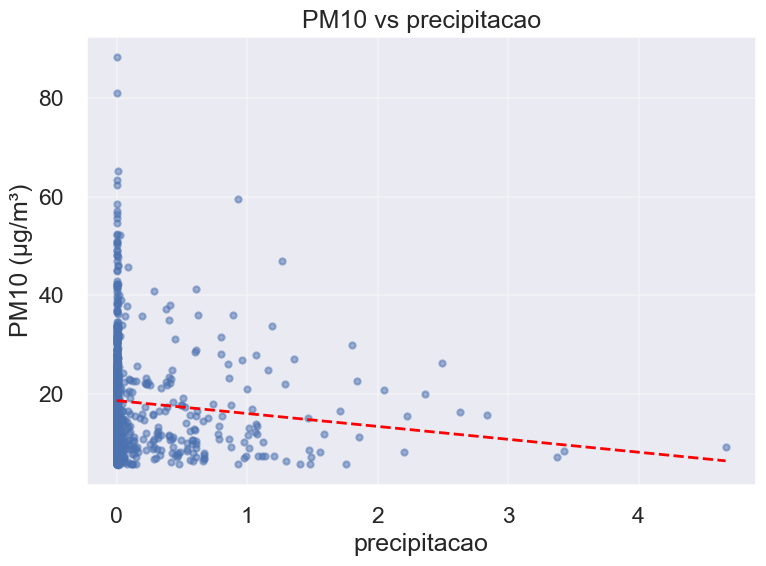

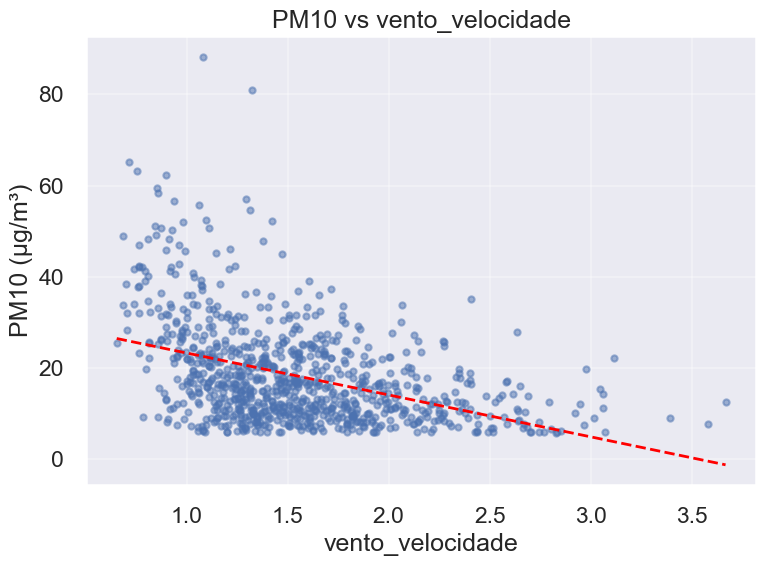

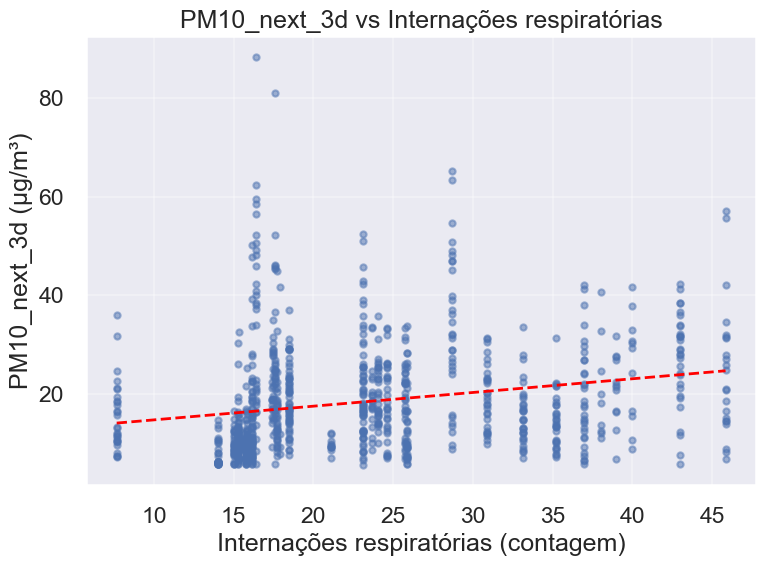

In [42]:
def scatter_with_trend(x, y, x_label, y_label, title, fname):
    tmp = pd.DataFrame({'x': x, 'y': y}).dropna()
    if tmp.shape[0] < 10:
        return
    plt.figure(figsize=(8,6))
    plt.scatter(tmp['x'], tmp['y'], alpha=0.5, s=20)
    try:
        z = np.polyfit(tmp['x'], tmp['y'], 1)
        p = np.poly1d(z)
        xs = np.linspace(tmp['x'].min(), tmp['x'].max(), 100)
        plt.plot(xs, p(xs), 'r--', linewidth=2)
    except Exception:
        pass
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    safe_savefig(fname)
    plt.show()

if 'PM10_Canoas' in df.columns:
    for m in ['umidade','temperatura','precipitacao','vento_velocidade']:
        if m in df.columns:
            scatter_with_trend(df[m], df['PM10_Canoas'], m, 'PM10 (µg/m³)', f'PM10 vs {m}', f'fe_scatter_PM10_vs_{m}.png')

# PM10 futuro vs internações
target_for_health = None
if 'PM10_next_day' in df.columns:
    target_for_health = 'PM10_next_day'
elif 'PM10_next_3d' in df.columns:
    target_for_health = 'PM10_next_3d'

if target_for_health and 'internacoes_respiratorias' in df.columns:
    scatter_with_trend(df['internacoes_respiratorias'], df[target_for_health],
                       'Internações respiratórias (contagem)', f'{target_for_health} (µg/m³)',
                       f'{target_for_health} vs Internações respiratórias',
                       f'fe_scatter_{target_for_health}_vs_internacoes.png')


## 9. Lags e Autocorrelação Visual
Correlação simples entre PM10 e seus lags principais, quando disponíveis no dataset de features.

Correlação de PM10_Canoas com seus lags:


PM10_Canoas_lag_1                   0.692721
PM10_Canoas_lag1                    0.692721
PM10_Canoas_lag_1_rolling_mean_3    0.599655
PM10_Canoas_lag2                    0.500149
PM10_Canoas_lag_1_lag1              0.500149
PM10_Canoas_lag_2                   0.500149
PM10_Canoas_lag_1_rolling_mean_7    0.491914
PM10_Canoas_lag_1_rolling_max_7     0.461352
PM10_Canoas_lag_2_rolling_mean_3    0.436692
PM10_Canoas_lag_7_rolling_std_7     0.404471
PM10_Canoas_lag_1_rolling_std_7     0.404346
PM10_Canoas_lag_2_rolling_mean_7    0.403391
PM10_Canoas_lag_2_rolling_max_7     0.400573
PM10_Canoas_lag_7_rolling_max_7     0.390954
PM10_Canoas_lag_1_rolling_min_7     0.371701
PM10_Canoas_lag_2_lag1              0.367637
PM10_Canoas_lag3                    0.367637
PM10_Canoas_lag_1_lag2              0.367637
PM10_Canoas_lag_3                   0.367637
PM10_Canoas_lag_2_rolling_std_7     0.367260
PM10_Canoas_lag_3_rolling_max_7     0.359576
PM10_Canoas_lag_7_rolling_mean_7    0.353004
PM10_Canoa

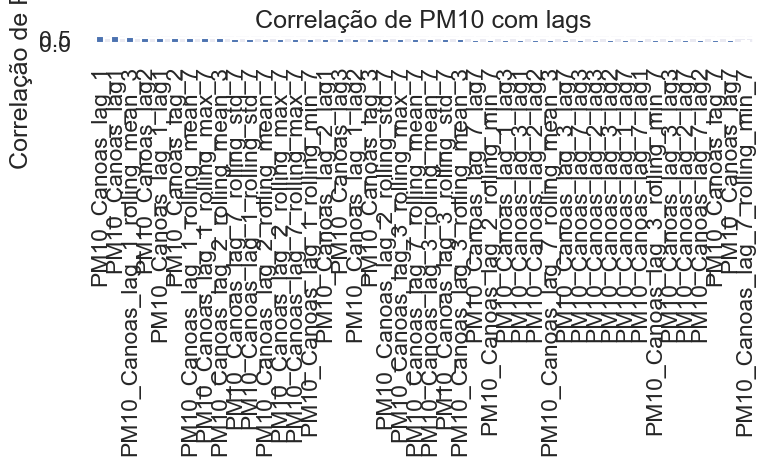

In [43]:
lag_cols = [c for c in df.columns if c.startswith('PM10_Canoas_lag')]
base_cols = ['PM10_Canoas'] + lag_cols
base_cols = [c for c in base_cols if c in df.columns]
if len(base_cols) >= 2:
    tmp = df[base_cols].dropna()
    corrs = tmp.corr()['PM10_Canoas'].drop('PM10_Canoas', errors='ignore').sort_values(ascending=False)
    print('Correlação de PM10_Canoas com seus lags:')
    display(corrs)
    plt.figure(figsize=(8,5))
    corrs.plot(kind='bar')
    plt.title('Correlação de PM10 com lags')
    plt.ylabel('Correlação de Pearson')
    plt.tight_layout()
    safe_savefig('fe_correlacao_PM10_lags.png')
    plt.show()
else:
    print('Lags de PM10 não encontrados no dataset atual.')


## 10. Relacionamento com Queimadas
Se presente, plota a série de PM10 e o número de focos de queimada no período, para avaliação exploratória de eventos extremos e co-ocorrência temporal.

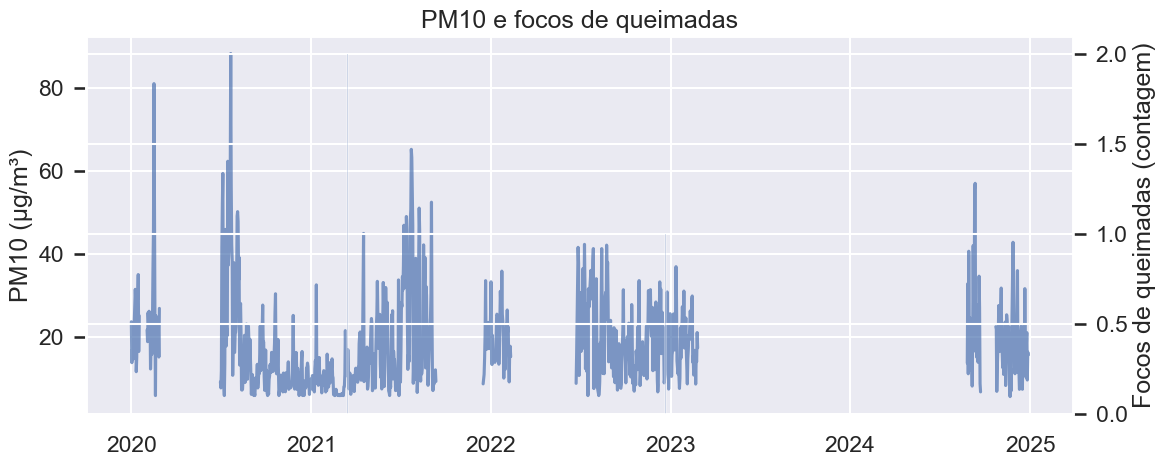

In [44]:
if 'PM10_Canoas' in df.columns and 'fire_count' in df.columns:
    fig, ax1 = plt.subplots(figsize=(12,5))
    ax1.plot(df.index, df['PM10_Canoas'], alpha=0.7)
    ax1.set_ylabel('PM10 (µg/m³)')
    ax2 = ax1.twinx()
    ax2.bar(df.index, df['fire_count'], alpha=0.3)
    ax2.set_ylabel('Focos de queimadas (contagem)')
    plt.title('PM10 e focos de queimadas')
    plt.tight_layout()
    safe_savefig('fe_PM10_vs_queimadas.png')
    plt.show()
else:
    print('Colunas necessárias para análise de queimadas não estão disponíveis.')


# Sumário dos Achados e Implicações para a Modelagem

## 1. Séries Temporais e Valores Faltantes

A série temporal do **PM₁₀** apresentou comportamento não estacionário, com tendência e padrões sazonais perceptíveis.
Foram observadas intermitências nos registros (períodos com e sem coleta), comuns em estações ambientais.
Nos períodos contínuos, destacaram-se picos acima de 80 µg/m³, correspondendo a episódios de poluição severa associados à inversão térmica, baixa dispersão e aumento das emissões urbanas.

A média móvel de 30 dias revelou tendência de aumento no inverno e redução no verão, evidenciando sazonalidade cíclica.
A variável-alvo **PM10_next_3d** manteve alta correlação com a série original, reforçando a importância das defasagens temporais curtas (lags) e médias móveis na modelagem.

As variáveis com maior percentual de valores faltantes foram as derivadas de lags e rollings, o que é esperado.
Dados meteorológicos e de saúde apresentaram boa completude, garantindo base sólida para regressão multivariada.

**Implicação:** a estrutura temporal e o padrão de faltantes suportam o uso de modelos preditivos temporais com lags, médias móveis e variáveis meteorológicas exógenas.

---

## 2. Distribuições e Outliers de Poluentes

O **PM₁₀** exibiu distribuição assimétrica à direita, com maioria dos valores abaixo de 30 µg/m³ e cauda longa de picos extremos (até 120 µg/m³).
Esses valores representam episódios reais e não devem ser removidos.

Os demais poluentes apresentaram padrões consistentes:
- **NO₂_Canoas:** levemente assimétrico, entre 5 e 15 µg/m³; reflete emissões veiculares.
- **O₃_Canoas:** cauda longa associada à radiação solar e estabilidade atmosférica.
- **SO₂_Canoas:** concentrado em valores baixos, com raros picos industriais.
- **CO_Canoas:** distribuição quase normal (~2 mg/m³), estável ao longo do tempo.

**Implicação:** os poluentes apresentam assimetria positiva e outliers informativos; transformações logarítmicas e escalonamento robusto são recomendáveis.
O conjunto reflete um ambiente urbano-industrial típico, com boa variabilidade entre poluentes.

---

## 3. Sazonalidade e Persistência Temporal

Os boxplots sazonais e mensais de **PM₁₀** e suas defasagens (lags 1–7) mostraram padrão sazonal forte e persistente:

- Inverno: maiores medianas e dispersão, devido à estabilidade atmosférica e inversão térmica.
- Verão e outono: menores concentrações médias, indicando maior dispersão.
- Primavera: comportamento intermediário e variável.

A autocorrelação entre defasagens foi alta, reforçando a persistência temporal.
O **CO_Canoas**, com baixa variação, serve como indicador contextual de poluição urbana.

**Implicação:** a sazonalidade robusta e a autocorrelação forte validam o uso de modelos autoregressivos e híbridos (ARIMA, LSTM, XGBoost temporal).

---

## 4. Relações entre Poluentes, Clima e Saúde

As relações bivariadas mostraram comportamentos fisicamente coerentes:

| Dimensão | Relação observada | Implicação |
|-----------|------------------|-------------|
| Vento | Correlação negativa forte | Vento dispersa poluentes — variável-chave |
| Precipitação | Correlação negativa moderada | Chuva reduz partículas suspensas ("washout") |
| Temperatura | Relação fraca / sazonal | Efeito indireto via estação do ano |
| Umidade | Correlação negativa leve | Reduz ressuspensão e estabiliza o ar |
| Focos de queimadas | Correlação positiva | Gatilho para picos de PM₁₀ |
| Internações respiratórias | Correlação positiva fraca | Indica risco à saúde pública |
| PM₁₀_lags | Alta autocorrelação | Persistência temporal relevante |

A matriz de correlação revelou:
- Alta correlação entre variáveis derivadas de PM₁₀ (lags e rollings).
- Correlação positiva entre poluentes urbanos (PM₁₀, NO₂, CO).
- Correlação negativa entre vento e PM₁₀.
- Associação positiva, ainda que discreta, entre PM₁₀ e internações respiratórias defasadas.

A decomposição temporal indicou tendência de queda entre 2020–2021 e aumento em 2022–2023, com forte sazonalidade invernal e resíduos bem distribuídos.

**Implicação:** o conjunto demonstra estrutura temporal estável e relações físicas consistentes, ideais para modelagem preditiva multivariada.

---

## 5. Síntese Geral dos Achados

1. **Sazonalidade e persistência temporal:** o PM₁₀ apresenta ciclos anuais regulares e autocorrelação até 7 dias, adequados a modelos temporais com lags e componentes sazonais.
2. **Variáveis meteorológicas como moderadores:** vento, precipitação, umidade e temperatura influenciam fortemente a dispersão e a concentração de poluentes.
3. **Fatores exógenos críticos:** focos de queimadas explicam picos agudos de poluição e devem ser incorporados como variáveis exógenas.
4. **Impacto na saúde:** há associação positiva entre PM₁₀ e internações respiratórias, reforçando a relevância social e preditiva do modelo.
5. **Estrutura de dados consistente:** apesar de lacunas, as séries mantêm coerência e estabilidade, favorecendo o uso de modelos de machine learning sensíveis à dinâmica temporal (XGBoost, LightGBM, Prophet, LSTM).

---

**Conclusão:**
A análise exploratória confirma que as concentrações de PM₁₀ em Canoas seguem padrões sazonais previsíveis, influenciados principalmente pelo clima, vento e eventos externos como queimadas.
Esses achados fornecem base sólida para a construção de um modelo preditivo robusto, explicável e aplicável à gestão da qualidade do ar e à antecipação de riscos à saúde pública na região metropolitana de Porto Alegre.
